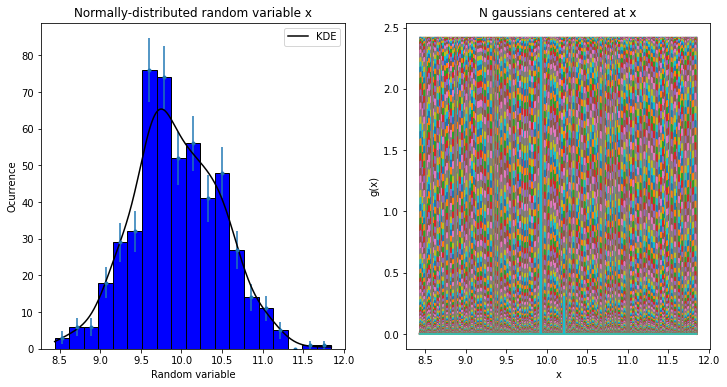

In [3]:
#1

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
from scipy import stats

N = 500
mu, sigma = 10.,0.5   # mean and standard deviation
x = np.random.normal(mu, sigma, N)


bn = np.arange(x.min(),x.max(),0.01) #number of bins
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

n, bins, _ = ax1.hist(x, bins="auto",color='blue', ec='black')
d = (bins[1]-bins[0])
ibn = [bins[0]+ d/2 + d*i for i in range(len(bins)-1)]
error = np.sqrt(n)

ax1.errorbar(ibn,n,yerr=error, fmt='.')
ax1.set_title('Normally-distributed random variable x')
ax1.set_ylabel('Ocurrence')
ax1.set_xlabel('Random variable')

gaussian_list = []
x_point = np.linspace(x.min(),x.max(),N)

for i in x:
    g_std  = 1.06 * x.std() * x.size**(-0.2)
    gaussian = norm.pdf(x_point,i,g_std)
    gaussian_list.append(gaussian)

ax2.plot(x_point,gaussian_list)
ax2.set_title('N gaussians centered at x')
ax2.set_ylabel('g(x)')
ax2.set_xlabel('x')


int_g = np.trapz(np.sum(gaussian_list,axis=0),x_point)
int_h = np.trapz(n,dx=d)
norm  = int_g/int_h                    #Normalisation constant

ax1.plot(x_point,np.sum(gaussian_list,axis =0)/norm, color='black', label='KDE')
ax1.legend()

plt.show()

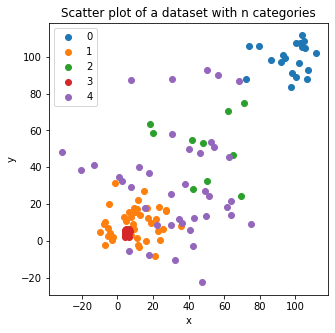

In [4]:
#2

def TDdataset(n,N,mu,sigma):
    dataset =[]
    
    for i in range(len(N)):
        l =np.arange(N[i])
        l.fill(int(i))
        x = np.random.normal(mu[i], sigma[i], (N[i],2))
        xl=np.c_[l,x]
        dataset.append(xl)       
    return dataset



n = 5
N = (20,40,10,20,40)
mu = (100.,10.,50,5,40)
sigma = (10.,10.,15,1.,30.)

a = TDdataset(n,N,mu,sigma)

fig, sct = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
for i in range(n):
    sct.scatter(a[i][:,1],a[i][:,2], label=str(int(a[i][0,0])))

sct.set_ylabel('y')
sct.set_xlabel('x')
plt.title('Scatter plot of a dataset with n categories')
plt.legend()
plt.show()

In [7]:
! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
data_r =pd.DataFrame(np.load('/home/atiye/Desktop/data/residuals_261.npy', allow_pickle=True).item())

# Data cleaning
data_r = data_r[abs(data_r['residuals'])<2.]
print(data_r)

#Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(data_r['distances'],data_r['residuals'])

#Seaborn Plot +  seaborn regression + scipy regression
plot = sns.lmplot(x='distances', y='residuals', data=data_r,
                  line_kws={'label':"Seaborn regression".format(slope,intercept),'color':'red','lw':'5'})
sns.set_style('whitegrid') 
plot.set(xlim=(-0.1,21))
distances = np.linspace(0,25,100,endpoint=True)
sns.lineplot(distances,distances*slope+intercept,color='orange', label = 'Scipy regression');

#Array filling
bins = 23
x = np.linspace(0,20,bins,endpoint=False)+(20/bins)/2  #Center of each bin

dx = x[1]-x[0]

y = np.array([(data_r[data_r['distances'].between(i-dx/2.,i+dx/2.)].mean(axis=0)[0]) for i in x])
erry = np.array([abs(data_r[data_r['distances'].between(i-dx/2.,i+dx/2.)].std(axis=0)[0]) for i in x])

#Plot adding
plt.errorbar(x,y,yerr=erry, fmt='.',color='black')
plt.show()

--2021-12-15 00:04:36--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [following]
--2021-12-15 00:04:36--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc336164f92838ed05244dc1877d.dl.dropboxusercontent.com/cd/0/inline/Bb1kT-jLtRjdu-ytnNAvtSOxnDR_KAfcZxeKRN-SXrJpIWWZk5gSbYtPNaKohaBoWSGmELlVMu98XnsM-AJnpXY1sARgwcqaWCzhZouOF7XbgE-VnxLSXfLL4S76uicKQedUGLd1yEKvIzXwBnMYWLNW/file# [following]
--2021-12-15 00:04:37--  https://uc336164f92838ed05244dc1877d.dl.dropboxusercontent.com/cd/0/inline/Bb1kT-jLtRjdu-ytnNAvtSOxnDR_KAfcZxeKRN-SXrJpIWWZk5gSbYtPNaKohaBoWSGmELlV

FileNotFoundError: [Errno 2] No such file or directory: '/home/atiye/Desktop/data/residuals_261.npy'